# 3D Convolutional Neural Network for Tomographic Alignment

## Expanding the Network: ResNet and Engineering the Data Again

Since based on previous analysis it is likely that the network was too small to properly identify the features necessary for alignment, the next logical step is to expand the network. Making deeper neural networks usually results in diminishing returns, but residual neural networks have proven to successfully allow for deeper neural networks. Now this model structure will be used in order to find some form of convergence.

While it seems like the ResNet will increase the performance of the model on larger training sets, testing convergence is still a major problem. Now the input data will be modified to find the difference between each projection which should help the network better isolate the pattern we want it to find. This will hopefully allow for better understanding of the specific alignment problem by the neural network.

In [1]:
# Import essential packages
import os
import math
import numpy as np
import matplotlib.pyplot as plt

# Import tomography and imaging packages
import tomopy
from skimage.transform import rotate, AffineTransform
from skimage import transform as tf
from scipy.fft import fft2, fftshift

# Import neural net packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.profiler
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torchinfo import summary

In [2]:
# Checking to ensure environment and cuda are correct
print("Working Environment: {}".format(os.environ['CONDA_DEFAULT_ENV']))
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print("Cuda Version: {}".format(torch.version.cuda))
print("Cuda Availability: {}".format(torch.cuda.is_available()))
!pwd

Working Environment: pytorch
Cuda Version: 11.8
Cuda Availability: True
/home/liam/Projects/Tomographic Alignment


In [3]:
# The resulting function that can be used for modifying the data
def data_mean_difference(data):
    
    # Create copy of dataset for projections to be modified, also initializes array for mean projections
    projections = data[:, 0].copy()
    mean_projections = np.zeros((projections.shape[0]), dtype = object)
    
    # Iterate through each projection stack
    for i in range (projections.shape[0]):

        # Get rid of extra dimensions for neural networks and create a mean projection
        projections[i] = np.squeeze(projections[i])
        mean_projections[i] = np.mean(projections[i], axis = 0)

        # Iterate through every projection in stack
        for j in range (projections[0].shape[0]):

            # Change current projection to difference between current projection and mean projection
            projections[i][j] = projections[i][j] - mean_projections[i]
            
        # Expand dimensions to original form for neural networks
        projections[i] = np.expand_dims(projections[i], axis = 0)
        projections[i] = np.expand_dims(projections[i], axis = 0)

    # Create data difference array
    data_diff = data.copy()

    # Replace all data with the new difference projections
    for i in range (data.shape[0]):

        data_diff[i][0] = projections[i]
        
    return data_diff

In [4]:
def data_difference(data, entries):

    data_diff = np.zeros((data.shape), dtype = object)
    projections = []

    for i in range (entries):
        projections.append(np.squeeze(data[:, 0][i]))

    projections = np.asarray(projections)

    differences = np.zeros((entries, projections[0].shape[0] - 1), dtype = object)

    for i in range (entries):

        for j in range (projections[0].shape[0] - 1):

            differences[i, j] = (projections[i][j + 1] - projections[i][j])

    for i in range (data_diff.shape[0]):

        data_diff[i][0] = np.zeros((differences.shape[1], differences[0, 0].shape[0], differences[0,0].shape[1]))
        data_diff[i][1] = data[i][1]

        for j in range (projections[0].shape[0] - 1):

            data_diff[i][0][j] = differences[i, j]

        data_diff[i][0] = np.expand_dims(data_diff[i][0], axis = 0)
        data_diff[i][0] = np.expand_dims(data_diff[i][0], axis = 0)

    return data_diff

In [5]:
def data_fourier_difference(data, entries):

    data_diff = np.zeros((data.shape), dtype = object)
    projections = []

    for i in range (entries):
        projections.append(np.squeeze(data[:, 0][i]))

    projections = np.asarray(projections)

    differences = np.zeros((entries, projections[0].shape[0] - 1), dtype = object)

    for i in range (entries):

        for j in range (projections[0].shape[0] - 1):

            differences[i, j] = fftshift(fft2((projections[i][j + 1] - projections[i][j])))

    for i in range (data_diff.shape[0]):

        data_diff[i][0] = np.zeros((differences.shape[1], differences[0, 0].shape[0], differences[0,0].shape[1]))
        data_diff[i][1] = data[i][1]

        for j in range (projections[0].shape[0] - 1):

            data_diff[i][0][j] = differences[i, j]

        data_diff[i][0] = np.expand_dims(data_diff[i][0], axis = 0)
        data_diff[i][0] = np.expand_dims(data_diff[i][0], axis = 0)

    return data_diff

In [6]:
# Loading data, 25 entries of 128 resolution shepp3ds
res = 128
entries = 25
data = []

for i in range(entries):
    data.append(np.load('./shepp{}-{}/shepp{}-{}_{}.npy'.format(res, entries, res, entries, i), 
                        allow_pickle = True))
    
data = np.asarray(data)


# data = data_mean_difference(data)
# data = data_difference(data, entries)
data = data_fourier_difference(data, entries)

/tmp/ipykernel_9422/3725346712.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
  data_diff[i][0][j] = differences[i, j]


In [7]:
# Checking shape of training and testing splits
trainset, testset = np.split(data, [int(entries * 4 / 5)])
print("Shape of Training Dataset: {}".format(trainset.shape))
print("Shape of Testing Dataset: {}".format(testset.shape))

Shape of Training Dataset: (20, 2)
Shape of Testing Dataset: (5, 2)


In [8]:
# Normalize data
def norm(proj):
    proj = (proj - torch.min(proj)) / (torch.max(proj) - torch.min(proj))
    return proj

# Get inplanes for resnet
def get_inplanes():
    return [64, 128, 256, 512]


# Preset for a 3x3x3 kernel convolution
def conv3x3x3(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=3,
                     stride=stride,
                     padding=1,
                     bias=False)


# Preset for a 1x1x1 kernel convolution
def conv1x1x1(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=1,
                     stride=stride,
                     bias=False)

# Basic block for resnet
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()

        self.conv1 = conv3x3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3x3(planes, planes)
        self.bn2 = nn.BatchNorm3d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
    
# Bottleneck block for resnet
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()

        self.conv1 = conv1x1x1(in_planes, planes)
        self.bn1 = nn.BatchNorm3d(planes)
        self.conv2 = conv3x3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm3d(planes)
        self.conv3 = conv1x1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm3d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
    

# Resnet structure
class ResNet(nn.Module):

    def __init__(self,
                 block,
                 layers,
                 block_inplanes,
                 n_input_channels=1,
                 conv1_t_size=7,
                 conv1_t_stride=1,
                 no_max_pool=False,
                 shortcut_type='B',
                 widen_factor=1.0,
                 n_classes=360):
        super().__init__()

        block_inplanes = [int(x * widen_factor) for x in block_inplanes]

        self.in_planes = block_inplanes[0]
        self.no_max_pool = no_max_pool

        self.conv1 = nn.Conv3d(n_input_channels,
                               self.in_planes,
                               kernel_size=(conv1_t_size, 7, 7),
                               stride=(conv1_t_stride, 2, 2),
                               padding=(conv1_t_size // 2, 3, 3),
                               bias=False)
        self.bn1 = nn.BatchNorm3d(self.in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, block_inplanes[0], layers[0],
                                       shortcut_type)
        self.layer2 = self._make_layer(block,
                                       block_inplanes[1],
                                       layers[1],
                                       shortcut_type,
                                       stride=2)
        self.layer3 = self._make_layer(block,
                                       block_inplanes[2],
                                       layers[2],
                                       shortcut_type,
                                       stride=2)
        self.layer4 = self._make_layer(block,
                                       block_inplanes[3],
                                       layers[3],
                                       shortcut_type,
                                       stride=2)

        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(block_inplanes[3] * block.expansion, n_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _downsample_basic_block(self, x, planes, stride):
        out = F.avg_pool3d(x, kernel_size=1, stride=stride)
        zero_pads = torch.zeros(out.size(0), planes - out.size(1), out.size(2),
                                out.size(3), out.size(4))
        if isinstance(out.data, torch.cuda.FloatTensor):
            zero_pads = zero_pads.cuda()

        out = torch.cat([out.data, zero_pads], dim=1)

        return out

    # make layer helper function
    def _make_layer(self, block, planes, blocks, shortcut_type, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            
                downsample = nn.Sequential(
                    conv1x1x1(self.in_planes, planes * block.expansion, stride),
                    nn.BatchNorm3d(planes * block.expansion))

        layers = []
        layers.append(
            block(in_planes=self.in_planes,
                  planes=planes,
                  stride=stride,
                  downsample=downsample))
        self.in_planes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.in_planes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        if not self.no_max_pool:
            x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


# Generates form of resnet
def generate_model(model_depth, **kwargs):
    assert model_depth in [10, 18, 34, 50, 101, 152, 200]

    if model_depth == 10:
        model = ResNet(BasicBlock, [1, 1, 1, 1], get_inplanes(), **kwargs)
    elif model_depth == 18:
        model = ResNet(BasicBlock, [2, 2, 2, 2], get_inplanes(), **kwargs)
    elif model_depth == 34:
        model = ResNet(BasicBlock, [3, 4, 6, 3], get_inplanes(), **kwargs)
    elif model_depth == 50:
        model = ResNet(Bottleneck, [3, 4, 6, 3], get_inplanes(), **kwargs)
    elif model_depth == 101:
        model = ResNet(Bottleneck, [3, 4, 23, 3], get_inplanes(), **kwargs)
    elif model_depth == 152:
        model = ResNet(Bottleneck, [3, 8, 36, 3], get_inplanes(), **kwargs)
    elif model_depth == 200:
        model = ResNet(Bottleneck, [3, 24, 36, 3], get_inplanes(), **kwargs)

    return model

In [9]:
model = generate_model(50)
summary(model, (1, 1, 180, 128, 184))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 360]                  --
├─Conv3d: 1-1                            [1, 64, 180, 64, 92]      21,952
├─BatchNorm3d: 1-2                       [1, 64, 180, 64, 92]      128
├─ReLU: 1-3                              [1, 64, 180, 64, 92]      --
├─MaxPool3d: 1-4                         [1, 64, 90, 32, 46]       --
├─Sequential: 1-5                        [1, 256, 90, 32, 46]      --
│    └─Bottleneck: 2-1                   [1, 256, 90, 32, 46]      --
│    │    └─Conv3d: 3-1                  [1, 64, 90, 32, 46]       4,096
│    │    └─BatchNorm3d: 3-2             [1, 64, 90, 32, 46]       128
│    │    └─ReLU: 3-3                    [1, 64, 90, 32, 46]       --
│    │    └─Conv3d: 3-4                  [1, 64, 90, 32, 46]       110,592
│    │    └─BatchNorm3d: 3-5             [1, 64, 90, 32, 46]       128
│    │    └─ReLU: 3-6                    [1, 64, 90, 32, 46]       --


In [10]:
torch.cuda.empty_cache()
print("Cleared Cache.")

Cleared Cache.


In [11]:
# Train the model

# Create writer and profiler to analyze loss over each epoch
writer = SummaryWriter()

# Set device to CUDA if available, initialize model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device: {}'.format(device))
net = generate_model(50)
net.to(device)

# Set up optimizer and loss function, set number of epochs
optimizer = optim.SGD(net.parameters(), lr = 5e-2, momentum=0.9, weight_decay = 0)
criterion = nn.MSELoss(reduction = 'mean')
criterion.to(device)
num_epochs = 500

# Iniitializing variables to show statistics
iteration = 0
test_iteration = 0
loss_list = []
test_loss_list = []
epoch_loss_averages = []
test_epoch_loss_averages = []

# Iterates over dataset multiple times
for epoch in range(num_epochs):
    
    epoch_loss = 0
    test_epoch_loss = 0
    
    for i, data in enumerate(trainset, 0):
        
        inputs, truths = norm(torch.from_numpy(data[0]).to(device).float()), torch.from_numpy(data[1]).to(device).float()
        optimizer.zero_grad()

        outputs = net(inputs).to(device)
        loss = criterion(outputs, truths)
        writer.add_scalar("Loss / Train", loss, epoch) # adds training loss scalar
        loss_list.append(loss.cpu().detach().numpy())
        epoch_loss += loss.cpu().detach().numpy()
        loss.backward()
        optimizer.step()

        iteration += 1
        if iteration % trainset.shape[0] == 0:
            epoch_loss_averages.append(epoch_loss / trainset.shape[0])
            print('Epoch: {}   Training Loss: {} '.format(epoch, epoch_loss / trainset.shape[0]))
            
    for i, test_data in enumerate(testset, 0):
        
        inputs, truths = norm(torch.from_numpy(test_data[0]).to(device).float()), torch.from_numpy(test_data[1]).to(device).float()
        outputs = net(inputs).to(device)
        test_loss = criterion(outputs, truths)
        
        writer.add_scalar("Loss / Test", test_loss, epoch) # adds testing loss scalar
        test_loss_list.append(test_loss.cpu().detach().numpy())
        test_epoch_loss += test_loss.cpu().detach().numpy()
        
        test_iteration +=1
        if test_iteration % testset.shape[0] == 0:
            test_epoch_loss_averages.append(test_epoch_loss / testset.shape[0])
            print('Epoch: {}   Validation Loss: {} '.format(epoch, test_epoch_loss / testset.shape[0]))
            
writer.flush()
writer.close()

Device: cuda:0
Epoch: 0   Training Loss: 12.478358221054076 
Epoch: 0   Validation Loss: 9.019415187835694 
Epoch: 1   Training Loss: 8.882289743423462 
Epoch: 1   Validation Loss: 8.312918090820313 
Epoch: 2   Training Loss: 8.582512068748475 
Epoch: 2   Validation Loss: 8.162690830230712 
Epoch: 3   Training Loss: 8.424197912216187 
Epoch: 3   Validation Loss: 8.1317889213562 
Epoch: 4   Training Loss: 8.356242871284485 
Epoch: 4   Validation Loss: 8.183088684082032 
Epoch: 5   Training Loss: 8.334106421470642 
Epoch: 5   Validation Loss: 8.205686092376709 
Epoch: 6   Training Loss: 8.31852421760559 
Epoch: 6   Validation Loss: 8.210098171234131 
Epoch: 7   Training Loss: 8.309296202659606 
Epoch: 7   Validation Loss: 8.215714645385741 
Epoch: 8   Training Loss: 8.301812410354614 
Epoch: 8   Validation Loss: 8.220040702819825 
Epoch: 9   Training Loss: 8.29720380306244 
Epoch: 9   Validation Loss: 8.222360610961914 
Epoch: 10   Training Loss: 8.29254491329193 
Epoch: 10   Validation 

Epoch: 88   Training Loss: 7.7759562015533445 
Epoch: 88   Validation Loss: 8.694788265228272 
Epoch: 89   Training Loss: 7.7999605417251585 
Epoch: 89   Validation Loss: 8.715804958343506 
Epoch: 90   Training Loss: 7.767492461204529 
Epoch: 90   Validation Loss: 8.69705638885498 
Epoch: 91   Training Loss: 7.8102538108825685 
Epoch: 91   Validation Loss: 8.60867519378662 
Epoch: 92   Training Loss: 7.758838391304016 
Epoch: 92   Validation Loss: 8.678618240356446 
Epoch: 93   Training Loss: 7.774008178710938 
Epoch: 93   Validation Loss: 8.687950134277344 
Epoch: 94   Training Loss: 7.755435347557068 
Epoch: 94   Validation Loss: 8.685706901550294 
Epoch: 95   Training Loss: 7.767667126655579 
Epoch: 95   Validation Loss: 8.715516948699952 
Epoch: 96   Training Loss: 7.753655219078064 
Epoch: 96   Validation Loss: 8.670452499389649 
Epoch: 97   Training Loss: 7.774787139892578 
Epoch: 97   Validation Loss: 8.687140655517577 
Epoch: 98   Training Loss: 7.734065747261047 
Epoch: 98   V

Epoch: 174   Training Loss: 6.390426564216614 
Epoch: 174   Validation Loss: 9.635372829437255 
Epoch: 175   Training Loss: 6.32117063999176 
Epoch: 175   Validation Loss: 9.59379186630249 
Epoch: 176   Training Loss: 6.273527073860168 
Epoch: 176   Validation Loss: 9.722858810424805 
Epoch: 177   Training Loss: 6.240243148803711 
Epoch: 177   Validation Loss: 9.3889723777771 
Epoch: 178   Training Loss: 6.221368908882141 
Epoch: 178   Validation Loss: 9.537961101531982 
Epoch: 179   Training Loss: 6.388083434104919 
Epoch: 179   Validation Loss: 10.069242477416992 
Epoch: 180   Training Loss: 6.983518457412719 
Epoch: 180   Validation Loss: 10.865226936340331 
Epoch: 181   Training Loss: 7.915625786781311 
Epoch: 181   Validation Loss: 9.26282033920288 
Epoch: 182   Training Loss: 7.571719694137573 
Epoch: 182   Validation Loss: 9.47595682144165 
Epoch: 183   Training Loss: 8.499570536613465 
Epoch: 183   Validation Loss: 8.665428924560548 
Epoch: 184   Training Loss: 7.79798738956451

Epoch: 260   Training Loss: 3.812689070403576 
Epoch: 260   Validation Loss: 10.771018314361573 
Epoch: 261   Training Loss: 3.6425383813679217 
Epoch: 261   Validation Loss: 11.334662818908692 
Epoch: 262   Training Loss: 3.65838812738657 
Epoch: 262   Validation Loss: 11.354077243804932 
Epoch: 263   Training Loss: 3.4083163395524023 
Epoch: 263   Validation Loss: 11.272729396820068 
Epoch: 264   Training Loss: 3.178080056980252 
Epoch: 264   Validation Loss: 11.42253074645996 
Epoch: 265   Training Loss: 3.047744948230684 
Epoch: 265   Validation Loss: 11.967663669586182 
Epoch: 266   Training Loss: 3.128268875181675 
Epoch: 266   Validation Loss: 11.560618591308593 
Epoch: 267   Training Loss: 2.966646933555603 
Epoch: 267   Validation Loss: 11.71749382019043 
Epoch: 268   Training Loss: 2.877592197805643 
Epoch: 268   Validation Loss: 11.84458885192871 
Epoch: 269   Training Loss: 3.1750986129045486 
Epoch: 269   Validation Loss: 11.935850715637207 
Epoch: 270   Training Loss: 3.4

Epoch: 344   Training Loss: 0.003008745418628678 
Epoch: 344   Validation Loss: 13.17842788696289 
Epoch: 345   Training Loss: 0.001582060076179914 
Epoch: 345   Validation Loss: 13.247931098937988 
Epoch: 346   Training Loss: 0.001246499033004511 
Epoch: 346   Validation Loss: 13.186736297607421 
Epoch: 347   Training Loss: 0.000668300014513079 
Epoch: 347   Validation Loss: 13.17369785308838 
Epoch: 348   Training Loss: 0.0005430667035398074 
Epoch: 348   Validation Loss: 13.217294502258301 
Epoch: 349   Training Loss: 0.00037528992361330894 
Epoch: 349   Validation Loss: 13.196099090576173 
Epoch: 350   Training Loss: 0.00024297708732774482 
Epoch: 350   Validation Loss: 13.18718662261963 
Epoch: 351   Training Loss: 0.00021869270276511087 
Epoch: 351   Validation Loss: 13.201391792297363 
Epoch: 352   Training Loss: 0.0001478953965488472 
Epoch: 352   Validation Loss: 13.198566246032716 
Epoch: 353   Training Loss: 0.00012101032298232895 
Epoch: 353   Validation Loss: 13.1867374420

Epoch: 425   Training Loss: 2.5306693657967115e-06 
Epoch: 425   Validation Loss: 13.193801879882812 
Epoch: 426   Training Loss: 1.5146514996899897e-06 
Epoch: 426   Validation Loss: 13.196046066284179 
Epoch: 427   Training Loss: 1.6031137228367243e-06 
Epoch: 427   Validation Loss: 13.197489166259766 
Epoch: 428   Training Loss: 1.3307497710002281e-06 
Epoch: 428   Validation Loss: 13.196464729309081 
Epoch: 429   Training Loss: 1.1050892389619094e-06 
Epoch: 429   Validation Loss: 13.200590896606446 
Epoch: 430   Training Loss: 1.1482102586057863e-06 
Epoch: 430   Validation Loss: 13.201840782165528 
Epoch: 431   Training Loss: 1.260225936050574e-06 
Epoch: 431   Validation Loss: 13.193739128112792 
Epoch: 432   Training Loss: 1.6263377929703892e-06 
Epoch: 432   Validation Loss: 13.196587371826173 
Epoch: 433   Training Loss: 1.4815313647886796e-06 
Epoch: 433   Validation Loss: 13.200528335571288 
Epoch: 434   Training Loss: 1.299308087254758e-06 
Epoch: 434   Validation Loss: 13

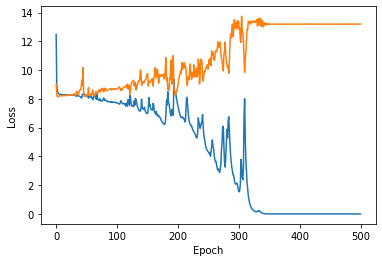

In [12]:
# Plot epoch loss to test for convergence
plt.plot(epoch_loss_averages)
plt.plot(test_epoch_loss_averages)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

This shows that there is still not testing convergence, so an alternative method will be tested.